In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersAlarms,
    ThrustersControl,
    ThrustersParameters,
)
from input_output.base import Stamped, StampedDf
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import thrusters_path
import polars as pl

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=49)
# time_index = pl.datetime_range(
#     start_time, start_time + duration, interval="1m", time_unit="us", eager=True
# )

# thrusters_pcs = StampedDf.stamp(
#     pl.DataFrame(
#         {
#             "time": time_index,
#             "value": 2 * ["off"] + 38 * ["propulsion"] + 10 * ["maneuvering"],
#         },
#     )
# )

# supply_temperature = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 20 * [60.0] + 30 * [85.0]})
# )
# fwd_thruster_active = StampedDf.stamp(
#     pl.DataFrame({
#         "time": time_index,
#         "value": 2 * ["False"] + 28 * ["True"] + 20 * ["False"],
#     })
# )
# fwd_thruster_heat = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 28 * [4300.0] + 20 * [0]})
# )

# aft_thruster_heat = StampedDf.stamp(
#     pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 48 * [9000.0]})
# )

# simulation_inputs = ThrustersSimulationInputs(
#     thrusters_aft=Thruster(heat_flow=aft_thruster_heat, active=Stamped.stamp(True)),
#     thrusters_fwd=Thruster(heat_flow=fwd_thruster_heat, active=fwd_thruster_active),
#     thrusters_seawater_supply=Boundary(
#         temperature=Stamped.stamp(32.0), flow=Stamped.stamp(64.0)
#     ),
#     thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
#     thrusters_pcs=Pcs(mode=thrusters_pcs),
# )

simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=Stamped.stamp(5000), active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=Stamped.stamp(5000), active=Stamped.stamp(True)),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(64.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=Stamped.stamp(60)),
    thrusters_pcs=Pcs(mode=Stamped.stamp("propulsion")),
)

control = ThrustersControl(
    ThrustersParameters())


thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with thrusters_model.executor() as executor:
    simulation = Simulator(thrusters_model, executor)

    #result = await simulation.run(int(duration.total_seconds()))
    result = await simulation.run(1500)



/Users/alje/Repos/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


(<Figure size 1000x1000 with 4 Axes>,
 array([<Axes: xlabel='time', ylabel='Control values [ratio]'>,
        <Axes: xlabel='time', ylabel='Valve position [ratio]'>,
        <Axes: xlabel='time', ylabel='Temperature [°C]'>,
        <Axes: xlabel='time', ylabel='Flow [l/min]'>], dtype=object))

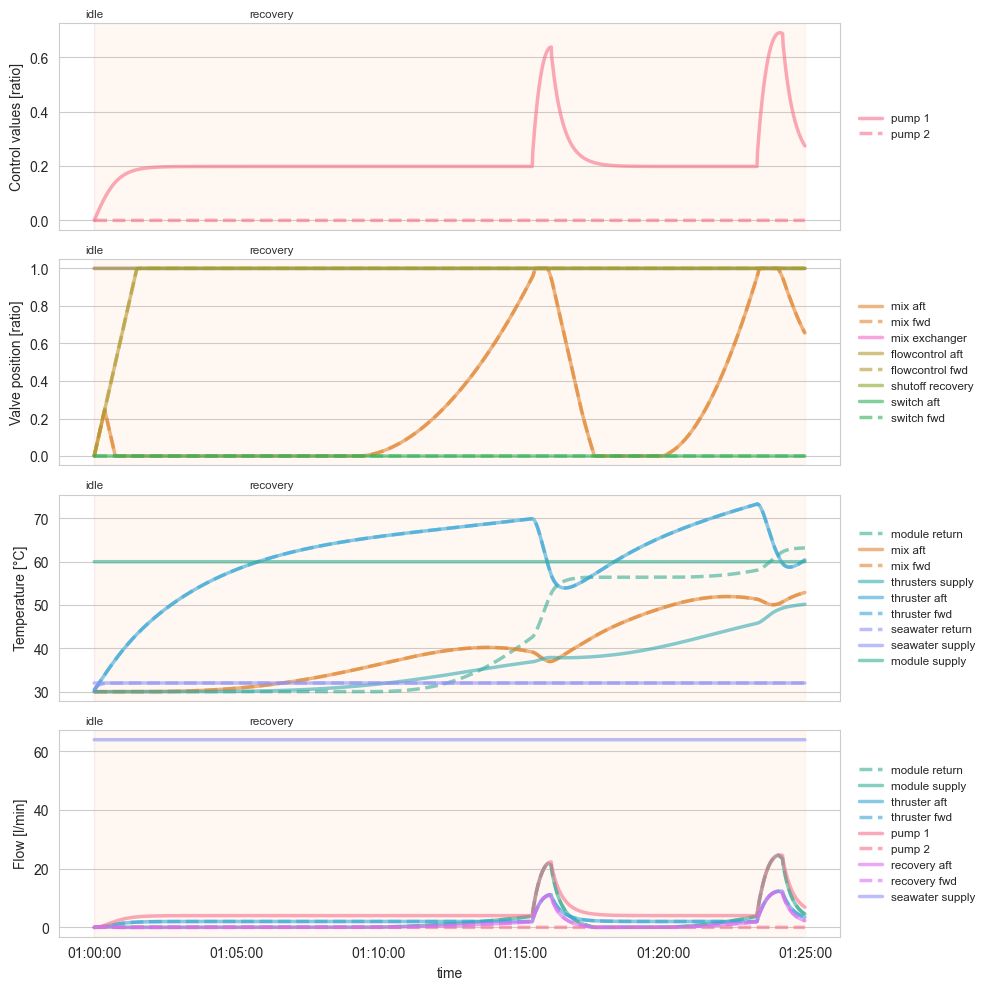

In [3]:
from analysis.analysis_utils import plot_result_by_variables
import seaborn as sns

palette = sns.color_palette("husl", 11)


variable_names = {
    "thrusters_pump_1__dutypoint__ratio": "pump 1",
    "thrusters_pump_2__dutypoint__ratio": "pump 2",
    "thrusters_mix_aft__position_rel__ratio": "mix aft",
    "thrusters_mix_fwd__position_rel__ratio": "mix fwd",
    "thrusters_mix_exchanger__position_rel__ratio": "mix exchanger",
    "thrusters_flowcontrol_aft__position_rel__ratio": "flowcontrol aft",
    "thrusters_flowcontrol_fwd__position_rel__ratio": "flowcontrol fwd",
    "thrusters_shutoff_recovery__position_rel__ratio": "shutoff recovery",
    "thrusters_switch_aft__position_rel__ratio": "switch aft",
    "thrusters_switch_fwd__position_rel__ratio": "switch fwd",
    "thrusters_module_return__temperature__C": "module return",
    "thrusters_temperature_aft_mix__temperature__C": "mix aft",
    "thrusters_temperature_fwd_mix__temperature__C": "mix fwd",
    "thrusters_temperature_supply__temperature__C": "thrusters supply",
    "thrusters_temperature_aft_return__temperature__C": "thruster aft",
    "thrusters_temperature_fwd_return__temperature__C": "thruster fwd",
    "thrusters_seawater_return__temperature__C": "seawater return",
    "thrusters_seawater_supply__temperature__C": "seawater supply",
    "thrusters_module_supply__temperature__C": "module supply",
    "thrusters_module_return__flow__l_min": "module return",
    "thrusters_module_supply__flow__l_min": "module supply",
    "thrusters_flow_aft__flow__l_min": "thruster aft",
    "thrusters_flow_fwd__flow__l_min": "thruster fwd",
    "thrusters_pump_1__flow__l_min": "pump 1",
    "thrusters_pump_2__flow__l_min": "pump 2",
    "thrusters_flow_recovery_aft__flow__l_min": "recovery aft",
    "thrusters_flow_recovery_fwd__flow__l_min": "recovery fwd",
    "thrusters_seawater_supply__flow__l_min": "seawater supply",
}

name_styles = {
    "pump 1": (palette[0], "-"),
    "pump 2": (palette[0], "--"),
    "mix aft": (palette[1], "-"),
    "mix fwd": (palette[1], "--"),
    "mix exchanger": (palette[10], "-"),
    "flowcontrol aft": (palette[2], "-"),
    "flowcontrol fwd": (palette[2], "--"),
    "shutoff recovery": (palette[3], "-"),
    "switch aft": (palette[4], "-"),
    "switch fwd": (palette[4], "--"),
    "module return": (palette[5], '--'),
    "module supply": (palette[5], '-'),
    "thrusters supply": (palette[6], '-'),
    "thruster aft": (palette[7], '-'),
    "thruster fwd": (palette[7], '--'),
    "seawater return": (palette[8], '--'),
    "seawater supply": (palette[8], '-'),
    "recovery aft": (palette[9],'-'),
    "recovery fwd": (palette[9],'--'),
}

control_palette = sns.color_palette("pastel", 4)
control_mode_styles = {
    "idle": control_palette[0],
    "recovery": control_palette[1],
    "cooling": control_palette[2],
    "safe": control_palette[3],
}

plot_result_by_variables(
    result,
    variable_names,
    name_styles,
    control_mode_styles,
    "plots/thrusters_consistent_colors.png",
)

In [ ]:
from datetime import datetime, timedelta
from control.modules.thrusters import (
    ThrustersAlarms,
    ThrustersControl,
    ThrustersParameters,
)
from input_output.base import Stamped
from input_output.definitions.simulation import (
    Boundary,
    Pcs,
    TemperatureBoundary,
    Thruster,
)
from input_output.modules.thrusters import (
    ThrustersControlValues,
    ThrustersSensorValues,
    ThrustersSimulationInputs,
    ThrustersSimulationOutputs,
)
from orchestration.simulator import Simulator, SimulatorModel
from simulation.models.fmu_paths import thrusters_path

start_time = datetime.fromtimestamp(0)
duration = timedelta(minutes=49)
time_index = pl.datetime_range(
    start_time, start_time + duration, interval="1m", time_unit="us", eager=True
)

thrusters_pcs = StampedDf.stamp(
    pl.DataFrame(
        {
            "time": time_index,
            "value": 2 * ["off"] + 38 * ["propulsion"] + 10 * ["maneuvering"],
        },
    )
)

supply_temperature = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 20 * [60.0] + 30 * [85.0]})
)
fwd_thruster_active = StampedDf.stamp(
    pl.DataFrame({
        "time": time_index,
        "value": 2 * ["False"] + 28 * ["True"] + 20 * ["False"],
    })
)
fwd_thruster_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 28 * [4300.0] + 20 * [0]})
)

aft_thruster_heat = StampedDf.stamp(
    pl.DataFrame({"time": time_index, "value": 2 * [0.0] + 48 * [9000.0]})
)

simulation_inputs = ThrustersSimulationInputs(
    thrusters_aft=Thruster(heat_flow=aft_thruster_heat, active=Stamped.stamp(True)),
    thrusters_fwd=Thruster(heat_flow=fwd_thruster_heat, active=fwd_thruster_active),
    thrusters_seawater_supply=Boundary(
        temperature=Stamped.stamp(32.0), flow=Stamped.stamp(64.0)
    ),
    thrusters_module_supply=TemperatureBoundary(temperature=supply_temperature),
    thrusters_pcs=Pcs(mode=thrusters_pcs),
)


control = ThrustersControl(
    ThrustersParameters())


thrusters_model = SimulatorModel(
    fmu_path=thrusters_path,
    sensor_values_cls=ThrustersSensorValues,
    control_values_cls=ThrustersControlValues,
    simulation_outputs_cls=ThrustersSimulationOutputs,
    simulation_inputs=simulation_inputs,
    control=control,
    alarms=ThrustersAlarms(),
    tick_duration=timedelta(seconds=1),
    start_time=start_time,
)

with thrusters_model.executor() as executor:
    simulation = Simulator(thrusters_model, executor)

    #result = await simulation.run(int(duration.total_seconds()))
    result = await simulation.run(1500)



/Users/alje/Repos/zero-thrs-control/src/orchestration/collector.py:25: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  self._data.vstack(pl.DataFrame({**values, 'time': time, 'control_mode': control_mode}, schema_overrides = self._schema, strict = False), in_place=True)


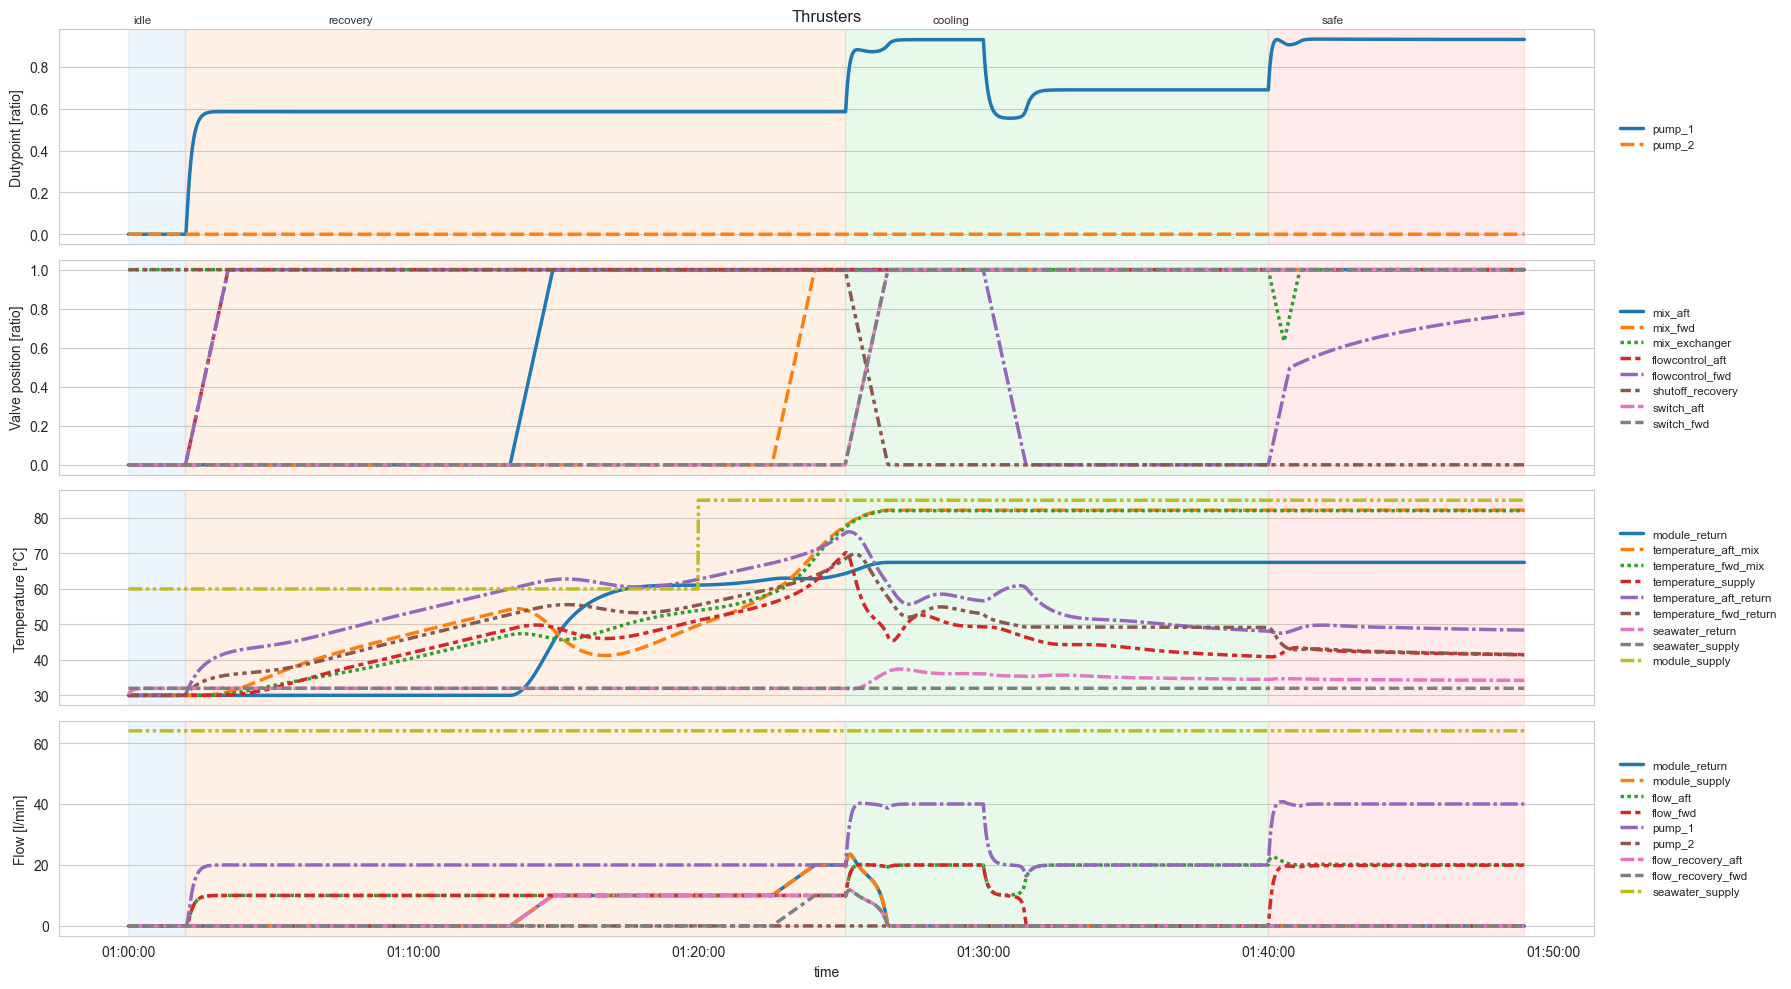

In [5]:
from analysis.analysis_utils import plot_result


plot_result(result, "plots/thrusters.png");

In [6]:
from transitions.extensions import GraphMachine
control = ThrustersControl(
    ThrustersParameters(
        cooling_mix_setpoint=40,
        recovery_thruster_flow=10,
        cooling_thruster_flow=20,
        max_inlet_temp=70,
        recovery_mix_setpoint=60,
    )
)
# without further arguments pygraphviz will be used
machine = GraphMachine(model=control, states = control._states, transitions=control._transitions, graph_engine = 'pygraphviz', initial = 'idle', show_conditions=True, show_state_attributes=True)

# draw the whole graph ...
control.get_graph().draw("thrusters_state_diagram.png", prog="dot")